# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

### 1. Determine if and why ML is an appropriate solution to deploy.

Machine Learning (ML) is an appropiate solution for this problem. First, we are trying to make predictions on the large amount of labeled flight delayed or not delayed data. Secondly, there are too many parameters for traditional statistical models to capture all of the behavior as we have around 4 years of historical data to identify patterns and make predictions. The data is also consistent, and most important our goal is clear (binary classification). If we can prepare model that can make accurate predictions it would be an appropiate solution to deploy.

### 2. Formulate the business problem, success metrics, and desired ML output.

**Business Problem**
A travel booking website wants to implement a feature that predicts if a flight will likely be delayed due to weather when customers book flights to or from the busiest airports in the U.S. This insight will allow customers to make informed decisions, potentially improving customer satisfaction and loyalty.

**Sucess Metrics**
Prediction Accuracy: A highly accuracy predicting model measured through metrics such as precision, recall, and F1-score.

### 3. Identify the type of ML problem you’re dealing with.

This is a **supervised binary** classification problem aimed at predicting whether a flight will be
delayed due to weather or not delayed based on 4 years of data data.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [2]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import glob

# Step 2: Data preprocessing and visualization  

In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [3]:
# relative paths
base_path = './'
zip_path = './data_compressed'
csv_base_path = './data_extracted'

# make dir if not exists
!mkdir -p {csv_base_path}

In [4]:
# How many zip files do we have? write a code to answer it.
zip_files_pattern = os.path.join(zip_path, "*.zip")
zip_files = glob.glob(zip_files_pattern)
len(zip_files)

60

#### Extract CSV files from ZIP files

In [5]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted")

Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_10.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_12.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_5.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_6.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_2.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2017_11.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_9.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_7.zip 
Extracting ./data_compressed/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_8.zi

In [6]:
from datetime import datetime
file_pattern = "./data_extracted/*.csv"
csv_files = glob.glob(file_pattern)

def file_year(filename):
    year_month = filename[-11:-4].strip()
    if "_" == year_month[0]:
        year_month = year_month[1:]

    d = datetime.strptime(year_month, '%Y_%d')
    return d  

# csv files name in ascending order 
csv_files = sorted(csv_files, key=file_year)

Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [7]:
from IPython.display import IFrame

readme_file_path = os.path.realpath(os.path.join(csv_base_path, "readme.html"))
IFrame(src=readme_file_path, width=600, height=400)

<CODE> #### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [8]:
file_1987 = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv'
file_path = os.path.join(csv_base_path, file_1987)
df_temp = pd.read_csv(file_path)
df_temp.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print the row and column length in the dataset, and print the column names.

In [9]:
df_shape = df_temp.shape 
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [10]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [11]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [12]:
for col in df_temp.columns:
    if "Del" in col:
        print(col)

DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
DivArrDelay


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [13]:
# shape of the dataset
print("The #rows and #columns are ", len(df_temp) , " and ", len(df_temp.columns))

# unique years in the dataset
print("The years in this dataset are: ", df_temp["Year"].unique())

# unique months in the dataset
print("The months covered in this dataset are: ", df_temp["Month"].unique())

# minimum and maximum date values
print("The date range for data is :" , min(df_temp["FlightDate"]), " to ", max(df_temp["FlightDate"]))

# unique airlines
print("The airlines covered in this dataset are: ", df_temp["Reporting_Airline"].unique())

# unique origins
print("The Origin airports covered are: ", list(df_temp["Origin"].unique()))

# unique destinations
print("The Destination airports covered are: ", list(df_temp["Dest"].unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E' 'B6' 'WN' 'YV' 'YX' 'EV' 'AA' 'AS' 'DL' 'HA' 'UA' 'F9' 'G4' 'MQ'
 'NK' 'OH' 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ', 'MLI', 'BHM'

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [14]:
counts = pd.DataFrame({"Origin": df_temp["Origin"].value_counts(), "Destination":df_temp["Dest"].value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [15]:
counts.sort_values(by="Origin", ascending=False).head(15)

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

First, we not we need to prepare a model that would find the patterns and then make prediction. The current dataset has too many features that are not helpful in finding patterns or preparing rules. We need to data processing before we can make predictions.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [16]:
## this new library is much faster than pd.read_csv()
import polars as pl


def combine_process(df, filter_cols, subset_cols, subset_vals):
    df = df[filter_cols]
    for idx, col in enumerate(subset_cols):
        df = df[df[col].isin(subset_vals[idx])]
    
    return df

# Instead of concatenating all files into one dataframe and then writing it, I am reading the contents of each file,
# and then appending it into the new file. This function keeps the memory low, and completed in under 2 minutes
# on my machine.
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """

    for files in csv_files:
        print("processing file", files)
        df = pl.read_csv(files).to_pandas()
        result = combine_process(df, filter_cols, subset_cols, subset_vals)
        result.to_csv(file_name, mode='a', header=False, index=False)

In [17]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [20]:
start = time.time()

combined_csv_filename = f"{base_path}/data/combined.csv"
combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)
print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_1.csv
processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_2.csv
processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_3.csv
processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_4.csv
processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_5.csv
processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_6.csv
processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_7.csv
processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_8.csv
processing file ./data_extracted/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2014_9.csv
processing file ./data_extracted/On_Time_Reporting_Carr

#### Load dataset

Load the combined dataset.

In [195]:
data = pd.read_csv(combined_csv_filename, names=cols)

Print the first 5 records.

In [196]:
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,0.0,0.0,689.0,3,-20.0,0.0,0.0,99.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,0.0,0.0,731.0,3,-3.0,0.0,0.0,98.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,0.0,0.0,1199.0,5,-7.0,0.0,0.0,174.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,0.0,0.0,1587.0,7,-4.0,0.0,0.0,233.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,0.0,0.0,1587.0,7,-13.0,0.0,0.0,179.0


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [197]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", len(data) , " and ", len(data.columns))
print("The years in this dataset are: ", data['Year'].unique())
print("The months covered in this dataset are: ", data['Month'].unique())
print("The date range for data is :" , min(data["FlightDate"]), " to ", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014 2015 2016 2017 2018]
The months covered in this dataset are:  [ 1  2  3  4  5  6  7  8  9 10 11 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

In [198]:
data.rename(columns={"ArrDel15": "is_delay"}, inplace=True)

In [199]:
print(data['is_delay'].unique())

[ 0.  1. nan]


Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

In [200]:
print("null values are \n", data.isnull().sum(axis= 0))

null values are 
 Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64


The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [201]:
data = data[~data['ArrDelay'].isnull() & ~data['ArrDelayMinutes'].isnull() & ~data['is_delay'].isnull() & ~data['AirTime'].isnull()]

# Confirm the number of rows after removing null values
print("Rows after removing null values:", data.shape[0])

Rows after removing null values: 1635590


Get the hour of the day in 24-hour time format from CRSDepTime.

In [202]:
data['DepHourofDay'] = data['CRSDepTime']  // 100

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

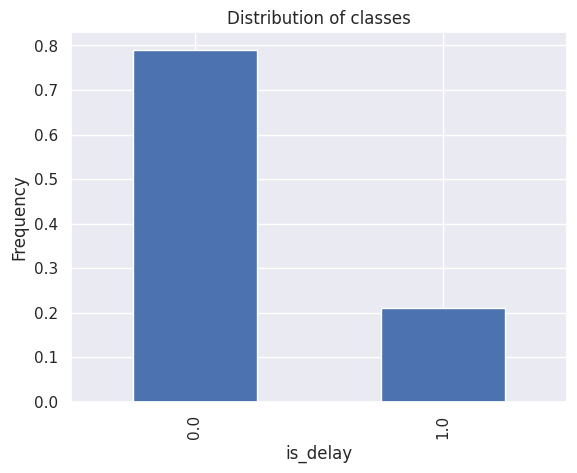

In [203]:
(data.groupby("is_delay").size() / len(data) ).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

The bar chart reveals that the majority of flights fall into the non delays category. The number of flights that are delays (represented by 1) are small as compared to the non delay (represented by 0).

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

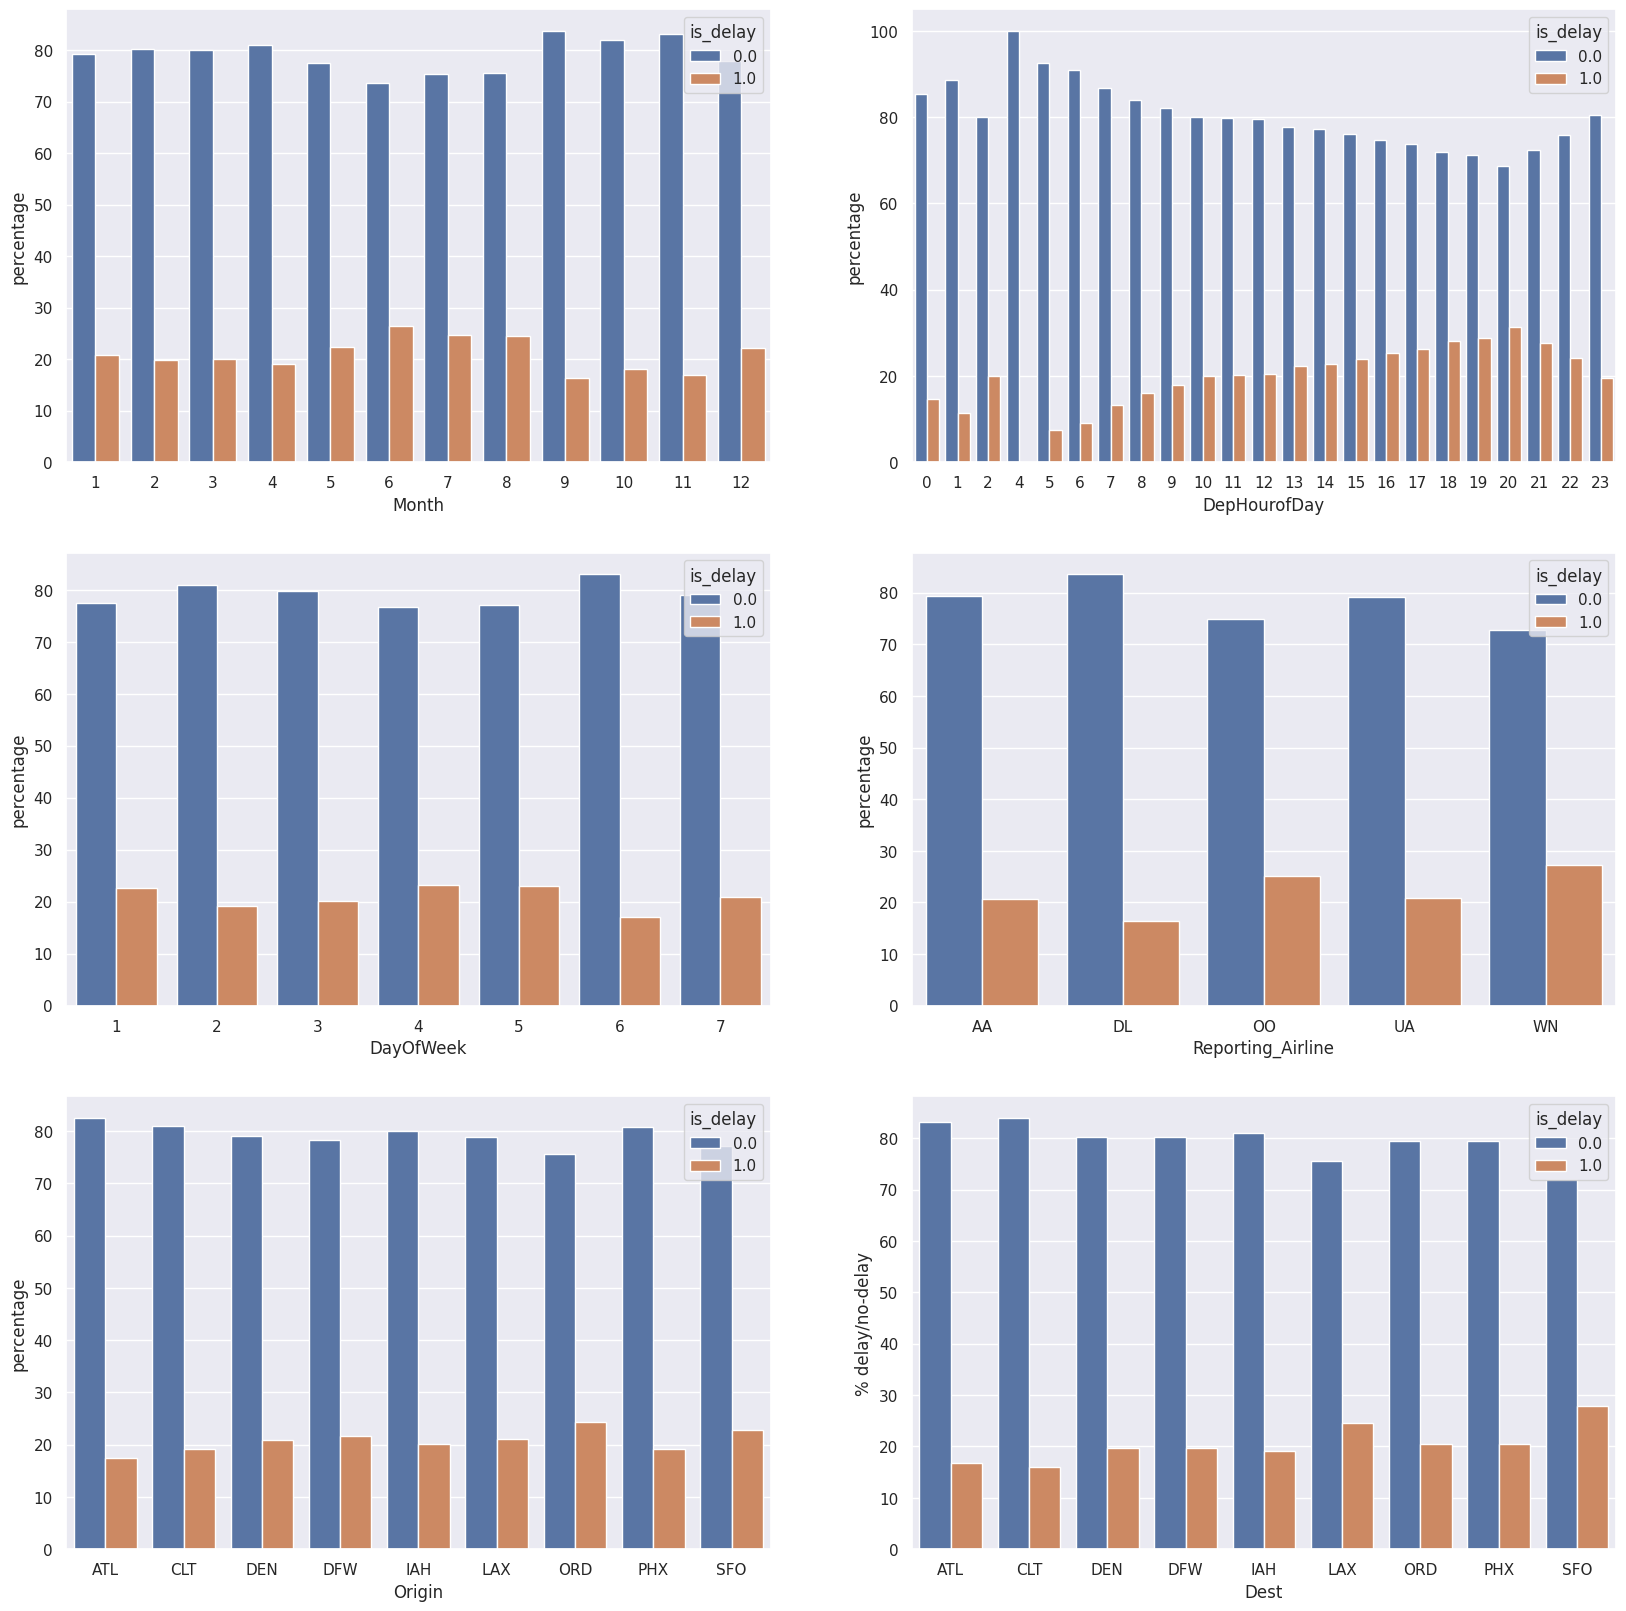

In [204]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

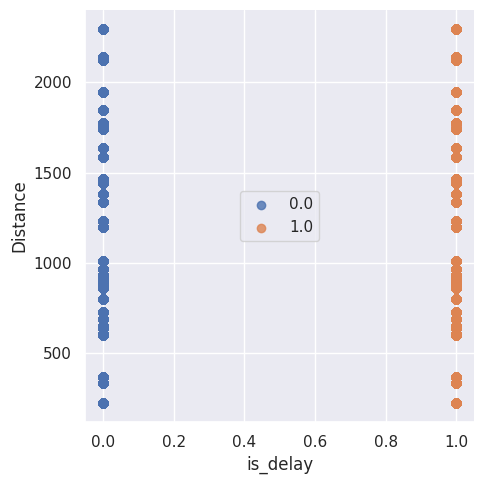

In [205]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

This scatter plot is showing the relation between the distance and the delay classes. However, there is no clear relation between flight distance and whether the flight be delayed or not. We can coclude that distance is not a feature that is signification when it comes to predicting.

### Features

Look at all the columns and what their specific types are.

In [182]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [206]:
print(len(data.columns))

21


In [207]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [208]:
data_orig = data.copy()

### Preparing DepHourOfDay Buckets Column Before Encoding

We are categorizing hour values into a general time-of-day bucket It works as follows:

- **Dawn:** Hours between 0 and 5 (inclusive).
- **Morning:** Hours between 6 and 11 (inclusive).
- **Evening:** Hours between 12 and 17 (inclusive).
- **Night:** Hours between 18 and 23 (inclusive).

In [209]:
def bucketize_hour(hour):
    if 0 <= hour <= 5:
        return "dawn" 
    elif 6 <= hour <= 11:
        return "morning" 
    elif 12 <= hour <= 17:
        return  "evening" 
    elif 18 <= hour <= 23:
        return "night" 

data['DepHourofDay_bucket'] = data['DepHourofDay'].apply(bucketize_hour)

In [210]:
# Drop the original DepHourofDay column
data = data.drop('DepHourofDay', axis=1)

In [211]:
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay_bucket']]

categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay_bucket']
for c in categorical_columns:
    data[c] = data[c].astype('category')

# Preview the data
data.head()

,is_delay,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,Distance,DepHourofDay_bucket
0,0.0,1,1,26,7,DL,ATL,IAH,689.0,night
1,0.0,1,1,26,7,DL,DFW,ATL,731.0,morning
2,0.0,1,1,26,7,DL,ATL,DEN,1199.0,night
3,0.0,1,1,26,7,DL,ATL,PHX,1587.0,evening
4,0.0,1,1,26,7,DL,PHX,ATL,1587.0,morning


To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

In [212]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True)
data_dummies = data_dummies.replace({True: 1, False: 0})
data = pd.concat([data, data_dummies], axis=1)
data.drop(categorical_columns, axis=1, inplace=True)

Check the length of the dataset and the new columnms.

In [213]:
data.shape

(1635590, 75)

In [214]:
print(data.columns)

Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN',

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

In [215]:
data.rename(columns={'is_delay': 'target'}, inplace=True)

In [216]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
data.to_csv("./data/combined_csv_v1.csv", index=False)

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [217]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target'] 

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Baseline classification model

In [218]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [219]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predictions on test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy score: {0:0.4f} \n'. format(accuracy))

cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix\n', cm)

Model accuracy score: 0.7903 


Confusion matrix
 [[258462     70]
 [ 68511     75]]


## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [220]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted)

    # Plotting the matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['No Delay', ' Delay'],
                yticklabels=['No Delay', 'Delay'])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()    

In [221]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

## Source: https://www.geeksforgeeks.org/how-to-plot-roc-curve-in-python/
def plot_roc(test_labels, target_predicted):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted) 
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure()  
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Breast Cancer Classification')
    plt.legend()
    plt.show()

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

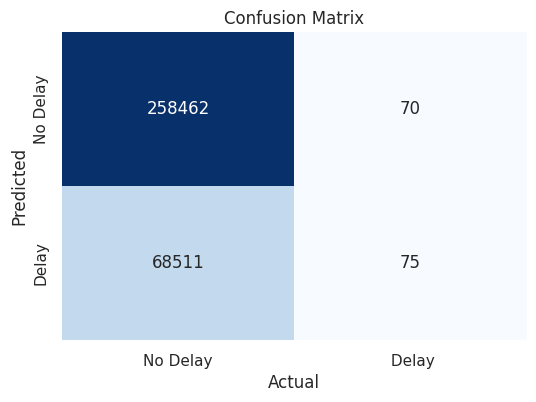

In [222]:
plot_confusion_matrix(y_test, y_pred)

<Axes: >

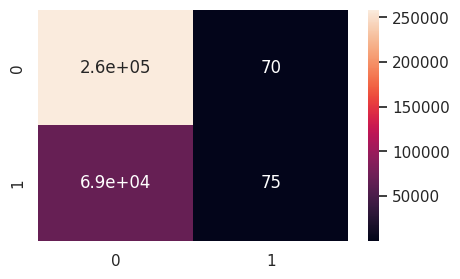

In [223]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize = (5,3))
sn.heatmap(cm, annot=True)

To print statistics and plot an ROC curve, call the `plot_roc` function on the `test_labels` and `target_predicted` data from your batch job:

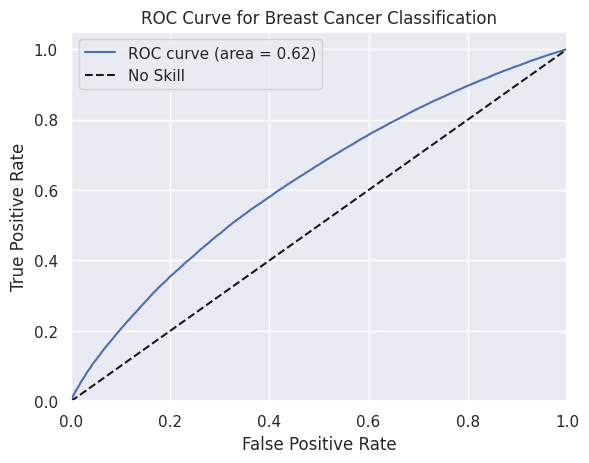

In [224]:
# Predict probabilities on the test set
y_pred_probs = model.predict_proba(X_test)[:, 1]
plot_roc(y_test, y_pred_probs)

In [225]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Print Evaluation Statistics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
sensitivity = recall  # Sensitivity is equivalent to recall in binary classification

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Detailed classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.79
Precision: 0.52
Recall (Sensitivity): 0.00
Specificity: 1.00
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    258532
         1.0       0.52      0.00      0.00     68586

    accuracy                           0.79    327118
   macro avg       0.65      0.50      0.44    327118
weighted avg       0.73      0.79      0.70    327118

Confusion Matrix:
 [[258462     70]
 [ 68511     75]]


### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.


**Question**: What can you summarize from the confusion matrix?


True Positives (TP): 75
(Predicted delay, actual delay)

False Positives (FP): 70
(Predicted delay, actual no delay)

True Negatives (TN): 25,862
(Predicted no delay, actual no delay)

False Negatives (FN): 68,511
(Predicted no delay, actual delay)

This confusion matrix suggests that the model is highly skewed towards predicting "No Delay" and has difficulty identifying actual delays accurately. This may indicate an imbalance in the training data or a need for model tuning to improve sensitivity towards the "Delay" class.

### How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

In our base model our recall score is very low (0.00), meaning the model is unable to identify any instances of the positive class (delays). This suggests that the model is likely biased towards predicting the majority class (non-delays), which is true as the model is highly biased because of more non delays values. We need to adjust the class weight in our next model.

From a business standpoint, recall is often crucial when predicting delays, as it’s important to capture as many true delays as possible, even if it means sacrificing some accuracy or precision.


# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


https://github.com/alleyshairu/flight-analysis

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [82]:
data_tmp = data_orig.copy()

In [83]:
data_orig = data_tmp
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = data_orig['FlightDate'].isin(holidays).astype(int)

In [84]:
## testing my assumption, the following should return 0 rows if the mapping worked
# as there no day 2 in 2014 where it was holidajy
# tmp = data_orig[(data_orig['is_holiday'] == 1) & (data_orig['Year'] == 2014) & (data_orig['DayofMonth'] == 2)]
# tmp.head()

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

In [85]:
# download data from the link above and place it into the data folder
weather = pd.read_csv("./data/daily-summaries.csv") # Enter your code here to read 'daily-summaries.csv' file
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0


Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [105]:
weather = pd.read_csv("./data/daily-summaries.csv") # Enter your code here to read 'daily-summaries.csv' file

station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

print(weather)
### Map weather stations to airport code
station_map = dict(zip(station,airports))
weather['airport'] = weather['STATION'].map(station_map)
weather.head()

           STATION        DATE  AWND  PRCP  SNOW  SNWD   TAVG   TMAX   TMIN
0      USW00023174  2014-01-01    16     0   NaN   NaN  131.0  178.0   78.0
1      USW00023174  2014-01-02    22     0   NaN   NaN  159.0  256.0  100.0
2      USW00023174  2014-01-03    17     0   NaN   NaN  140.0  178.0   83.0
3      USW00023174  2014-01-04    18     0   NaN   NaN  136.0  183.0  100.0
4      USW00023174  2014-01-05    18     0   NaN   NaN  151.0  244.0   83.0
...            ...         ...   ...   ...   ...   ...    ...    ...    ...
16429  USW00013881  2018-12-27    31    41   0.0   0.0   68.0   89.0   39.0
16430  USW00013881  2018-12-28    27   196   0.0   0.0   86.0  144.0   61.0
16431  USW00013881  2018-12-29    14     0   0.0   0.0  146.0  189.0   94.0
16432  USW00013881  2018-12-30    16    23   0.0   0.0  117.0  139.0   89.0
16433  USW00013881  2018-12-31    29    41   0.0   0.0  135.0  194.0  117.0

[16434 rows x 9 columns]


,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX


In [106]:
## testing the following should return 0
weather[(weather["STATION"] == "USW00023174") & (weather["airport"].isin(airports[1:]))]

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport


Create another column called `MONTH` from the `DATE` column.

In [108]:
weather['MONTH'] = weather["DATE"].apply(lambda x: x.split('-')[1])# Enter your code here 
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [109]:
weather.SNOW.fillna(0, inplace=True)
weather.SNWD.fillna(0, inplace=True)
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

In [110]:
idx = np.array([i for i in range(len(weather))])

# Find the rows with missing values in TAVG, TMAX, and TMIN
TAVG_idx = weather.TAVG[idx].isna()
TMAX_idx = weather.TMAX[idx].isna()
TMIN_idx = weather.TMIN[idx].isna()

# Print indices of rows with missing values for each column
print("Indices with missing TAVG:", idx[TAVG_idx])
print("Indices with missing TMAX:", idx[TMAX_idx])
print("Indices with missing TMIN:", idx[TMIN_idx])

Indices with missing TAVG: [ 3956  3957  3958  3959  3960  3961  3962  3963  3964  3965  3966  3967
  3968  3969  3970  3971  3972  3973  3974  3975  3976  3977  3978  3979
  3980  3981  3982  3983  3984  3985  4017  4018  4019  4020  4021  4022
  4023  4024  4025  4026  4027  4028  4029  4030  4031  4032  4033  4034
  4035  4036  4037  4038  4039  4040  4041  4042  4043  4044  4045  4046
  4047 13420]
Indices with missing TMAX: [10763 10764 10765 10766 10767 10768 10769 10770 10771 10772 10773 10774
 10775 10776 10777 10778 10779 10780 10781 10782]
Indices with missing TMIN: [10763 10764 10765 10766 10767 10768 10769 10770 10771 10772 10773 10774
 10775 10776 10777 10778 10779 10780 10781 10782]


You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [111]:
weather_impute = weather.groupby(["STATION", "MONTH"]).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()
weather_impute.head(2)

,STATION,MONTH,TAVG,TMAX,TMIN
0,USW00003017,01,-2.741935,74.000000,-69.858065
1,USW00003017,02,11.219858,88.553191,-65.035461


Merge the mean data with the weather data.

In [112]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [114]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [115]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [116]:
# Ensure FlightDate in data_orig is in datetime format
data_orig['FlightDate'] = pd.to_datetime(data_orig['FlightDate'])

# Ensure DATE in weather is in datetime format
weather['DATE'] = pd.to_datetime(weather['DATE'])

### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

In [338]:
data_orig.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,...,SNOW_D,TAVG_D,AWND_O,PRCP_O,SNOW_O,TAVG_O,AWND_D,PRCP_D,SNOW_D,TAVG_D
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,...,0.0,130.0,33,0,0.0,54.0,30,0,0.0,130.0
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,...,0.0,54.0,39,0,0.0,136.0,33,0,0.0,54.0
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,...,0.0,68.0,33,0,0.0,54.0,77,0,0.0,68.0
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,...,SNOW,165.0,33,0,0.0,54.0,20,0,SNOW,165.0
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,...,0.0,54.0,20,0,SNOW,165.0,33,0,0.0,54.0


**Note**: It is always a good practice to check nulls/NAs after joins.

In [117]:
sum(data_orig.isna().any())

0

In [119]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [120]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [121]:
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data_dummies = data_dummies.replace({True: 1, False: 0})
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

In [123]:
data.shape

(1635590, 86)

Check the new columns.

In [124]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

Rename the `is_delay` column to `target` again. Use the same code as before.

In [125]:
data.rename(columns = {'is_delay':'target'}, inplace=True )

In [127]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
data.to_csv("./data/combined_csv_v2.csv", index=False)

Create the training and testing sets again.

In [128]:
data.dtypes

target          float64
Distance        float64
DepHourofDay      int64
AWND_O            int64
PRCP_O            int64
                 ...   
Dest_LAX          int64
Dest_ORD          int64
Dest_PHX          int64
Dest_SFO          int64
is_holiday_1      int64
Length: 86, dtype: object

In [129]:
data["SNOW_O"]

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1635585    0.0
1635586    0.0
1635587    0.0
1635588    0.0
1635589    0.0
Name: SNOW_O, Length: 1635590, dtype: float64

In [131]:
for col in data.columns:
    print(col)


target
Distance
DepHourofDay
AWND_O
PRCP_O
TAVG_O
AWND_D
PRCP_D
TAVG_D
SNOW_O
SNOW_D
Year_2015
Year_2016
Year_2017
Year_2018
Quarter_2
Quarter_3
Quarter_4
Month_2
Month_3
Month_4
Month_5
Month_6
Month_7
Month_8
Month_9
Month_10
Month_11
Month_12
DayofMonth_2
DayofMonth_3
DayofMonth_4
DayofMonth_5
DayofMonth_6
DayofMonth_7
DayofMonth_8
DayofMonth_9
DayofMonth_10
DayofMonth_11
DayofMonth_12
DayofMonth_13
DayofMonth_14
DayofMonth_15
DayofMonth_16
DayofMonth_17
DayofMonth_18
DayofMonth_19
DayofMonth_20
DayofMonth_21
DayofMonth_22
DayofMonth_23
DayofMonth_24
DayofMonth_25
DayofMonth_26
DayofMonth_27
DayofMonth_28
DayofMonth_29
DayofMonth_30
DayofMonth_31
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
Reporting_Airline_DL
Reporting_Airline_OO
Reporting_Airline_UA
Reporting_Airline_WN
Origin_CLT
Origin_DEN
Origin_DFW
Origin_IAH
Origin_LAX
Origin_ORD
Origin_PHX
Origin_SFO
Dest_CLT
Dest_DEN
Dest_DFW
Dest_IAH
Dest_LAX
Dest_ORD
Dest_PHX
Dest_SFO
is_holiday_1


In [132]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [165]:
from sklearn.linear_model import LogisticRegression

classifier2 = LogisticRegression(class_weight='balanced')
classifier2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [189]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predictions on test set
y_pred = classifier2.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression Model: {accuracy:.2f}")

# Detailed classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print Evaluation Statistics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
sensitivity = recall  # Sensitivity is equivalent to recall in binary classification

print()
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Accuracy of Logistic Regression Model: 0.62
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.62      0.72    258532
         1.0       0.29      0.58      0.39     68586

    accuracy                           0.62    327118
   macro avg       0.57      0.60      0.55    327118
weighted avg       0.73      0.62      0.65    327118

Confusion Matrix:
 [[161483  97049]
 [ 28841  39745]]

Accuracy: 0.62
Precision: 0.29
Recall (Sensitivity): 0.58
Specificity: 0.62


Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

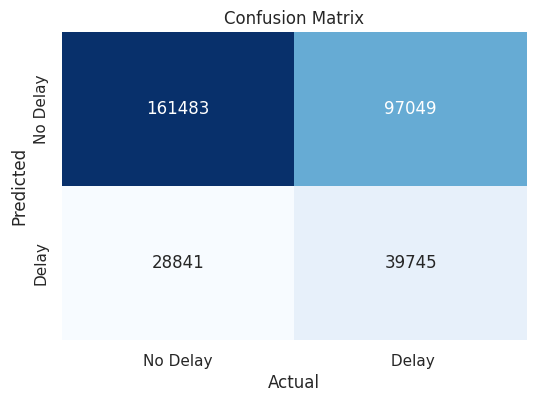

In [167]:
plot_confusion_matrix(y_test, y_pred)

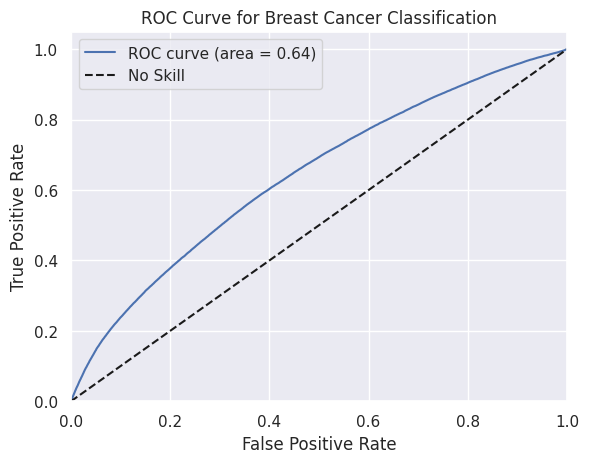

In [168]:
y_pred_probs = classifier2.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (delay)
plot_roc(y_test, y_pred_probs)

### Step 6: Using Tableau


**SHEET 1: Daily Peak Times:**
https://public.tableau.com/app/profile/sher.afgan4743/viz/DailyPeakTimes/Sheet1

**SHEET 2: Average Arrival Delay:**
https://public.tableau.com/app/profile/sher.afgan4743/viz/AveragearrivalDelay/Sheet1

### GitHub

**REPOSITORY LINK:** https://github.com/alleyshairu/flight-analysis

### Model Comparison

| Metric                  | Model 1       | Model 2 (Enhanced)|
|-------------------------|---------------|-----------------|
| **Accuracy**            | 0.79          | 0.62           |
| **Precision (Class 1)** | 0.52          | 0.29           |
| **Recall (Class 1)**    | 0.00          | 0.58           |
| **Specificity (Class 0)** | 1.00        | 0.62           |
| **F1-Score (Class 1)**  | 0.00          | 0.39           |


Confusion Matrix Comparison

| **Confusion Matrix**                  | Model 1       | Model 2 (Enhanced)|
|---------------------------------------|---------------|-----------------|
| True Negatives (TN)                   | 258462        | 161483         |
| False Positives (FP)                  | 70            | 97049          |
| False Negatives (FN)                  | 68511         | 28841          |
| True Positives (TP)                   | 75            | 39745          |


## Conclusion

#### Model Performance meets Business goal

Our second iteration of model meets the business goal requirement. After balancing the class weight we are able to able to predict much higher values of delays as compared to our previous model. Predicting delays when there is a delay was our true business goal. We get moderate true positive of around (39745) which means the model misses some delay cases, indicating it could be optimized to capture more delays. Even though our accuracy is low in model 2, but it is the model that meets our business requirement.

However, there are a considerable number of cases where the model predicts a delay when there is actually no delay, which could lead to unnecessary alerts or interventions.

Our enhanced models even after balancing class weight and feature engineering needs more improvement, as the model still seems to be leaning towards predicting No Delay more accurately. 

### Techniques For Model Improvement

For model improvement I utilized several techniques such replacing values, bucketing values, encoding, and removing null values—to optimize model performance significantly.

- Balancing class weight using scikit-learn `class_weight=balanced`.

- Bucketing was used to convert continuous variables into specific categories, reducing complexity and helping the model to capture patterns more effectively without being overly sensitive to outliers.

- Encoding of categorical data transformed non-numeric information into a numerical format that the model could interpret, preserving critical information and enhancing the model’s ability to generalize across different data types.

- Removing Null Values ensured that the dataset was complete and clean, preventing potential inaccuracies that could arise from missing data points, thus creating a more reliable foundation for model training.

### Biggest Challenges

- One of the biggest challenges in this project was working with the massive dataset, as it was my first time handling data of this scale. Combining multiple data sources was time-consuming than I initially anticipated. I spent more time waiting for the combining process to complete until I found a solution that was doing it in less than 2 minutes. 

- This experience also taught me about the differences in processing speed at different stages of data handling. Reading large files took far longer than actually processing or writing data. I basically logged at every step to find which step was taking the most time which later I optimized so that I can keep making small changes to the data and modelling step.

- I also found it difficult to make incremental changes to data preparation and modelling step. For most part of the assignment I spent my time doing everything from scratch for evey small incremental change. I did try using temporary variable to save intermediate state, but still I had to re run all the steps sometimes.

 

### What I learned

- First I learned that reading large files into memory is much slower than actually performing operation and writing data back to the file. For example, reading one single data of the given dataset took around 8-9 seconds, while the whole combine process (filtering, subsetting) and writing back to an existing file took lesson much less than that on my machine.

- I also struggled with keep tracking of data variable in such a large single notebook. Sometimes, I test my assumptions by changing and mutating the dataframe, and then I had to run all the previous steps again such as (combining) which are very time consuming. The trick I used to overcome this is to save my so far processed dataframe state in some temporary variable and then assign it back to the variable I am working on. This helped me to go back the previous state of my dataframe without having to run all the previous cell.

- The other thing which I learned was how to make sense of the confusion matrix results generated using scikit learn. I wish the API was more clear in terms of what is true positive, or true negative, and so on. You never know what does (0,0) (0,1) represent. It depends on how you are framing your problem and evaluating reults.

- Finally, I learned that it is not just about having models with high accuracy and precision values, it all depends on the answers or business problem statement that we are trying to solve. For example, in our scenario, first model has higher accuracy than second model, but it is the second model that is meeting our business requirements.